### Домашнее задание основано на соревновании: 
https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data
#### Цель: обучить текстовый классификатор на простых фичах с помощью Spark ML
1) HashingTF и IDF - 70 баллов - в ноутбуке **hw5_pyspark_TFIDF**
2) **Word2Vec - 30 баллов**<br>

ДЗ предлагается сделать в ноутбуке и в формате ipynb загрузить в репозиторий на Github и прислать ссылку на него в интерфейсе сдачи

## Необходимые библиотеки

In [1]:
import findspark
findspark.init("/opt/spark")
import random
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF
from pyspark.ml.feature import Word2Vec
from pyspark.ml.classification import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
spark = SparkSession.builder.appName('word2vec').getOrCreate()

22/12/05 15:26:02 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Загрузка данных

Загружаем только тренировочные данные, на них будем учить и валидировать. Для тестовых данных меток на kaggle нет, поэтому их не рассматриваем.

In [3]:
# Так не вышло считать - криво разбивалось из-за запятых и \n в текстах
# Использовала предобработанный датасет ниже
#df = spark.read.option("lineSep", "\n").option("multiLine","true").csv("data/train.csv", header = True, inferSchema = True)
#df.printSchema()

In [4]:
df = spark.read.csv("data/train_prep.csv", header = True, inferSchema = True)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- toxic: integer (nullable = true)
 |-- severe_toxic: integer (nullable = true)
 |-- obscene: integer (nullable = true)
 |-- threat: integer (nullable = true)
 |-- insult: integer (nullable = true)
 |-- identity_hate: integer (nullable = true)



Посмотрим на данные

In [5]:
print((df.count(), len(df.columns)))

(159571, 8)


In [6]:
df.show(10)

+----------------+--------------------+-----+------------+-------+------+------+-------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
|0000997932d777bf|ExplanationWhy th...|    0|           0|      0|     0|     0|            0|
|000103f0d9cfb60f|D'aww! He matches...|    0|           0|      0|     0|     0|            0|
|000113f07ec002fd|Hey man I'm reall...|    0|           0|      0|     0|     0|            0|
|0001b41b1c6bb37e|"""MoreI can't ma...|    0|           0|      0|     0|     0|            0|
|0001d958c54c6e35|You sir are my he...|    0|           0|      0|     0|     0|            0|
|00025465d4725e87|"""Congratulation...|    0|           0|      0|     0|     0|            0|
|0002bcb3da6cb337|COCKSUCKER BEFORE...|    1|           1|      1|     0|     1|            0|
|00031b1e95af7921|Your vandalism to...|    0|     

## Подготовка данных

Посмотрим, где есть пропуски.

In [7]:
print(f"Пропуски в колонке id: {df.filter('id IS NULL').count()} ({100 * df.filter('id IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке comment_text: {df.filter('comment_text IS NULL').count()} ({100* df.filter('comment_text IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке toxic: {df.filter('toxic IS NULL').count()} ({100 * df.filter('toxic IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке severe_toxic: {df.filter('severe_toxic IS NULL').count()} ({100 * df.filter('severe_toxic IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке obscene: {df.filter('obscene IS NULL').count()} ({100 * df.filter('obscene IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке threat: {df.filter('threat IS NULL').count()} ({100 * df.filter('threat IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке insult: {df.filter('insult IS NULL').count()} ({100 * df.filter('insult IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке identity_hate: {df.filter('identity_hate IS NULL').count()} ({100 * df.filter('identity_hate IS NULL').count() / df.count():.2f})%")

Пропуски в колонке id: 0 (0.00)%
Пропуски в колонке comment_text: 0 (0.00)%
Пропуски в колонке toxic: 8 (0.01)%
Пропуски в колонке severe_toxic: 8 (0.01)%
Пропуски в колонке obscene: 8 (0.01)%
Пропуски в колонке threat: 8 (0.01)%
Пропуски в колонке insult: 8 (0.01)%
Пропуски в колонке identity_hate: 8 (0.01)%


Удалим строки, где есть пропуски

In [8]:
df = df.dropna()
print(df.count())

159563


In [9]:
print(f"Пропуски в колонке id: {df.filter('id IS NULL').count()} ({100 * df.filter('id IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке comment_text: {df.filter('comment_text IS NULL').count()} ({100* df.filter('comment_text IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке toxic: {df.filter('toxic IS NULL').count()} ({100 * df.filter('toxic IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке severe_toxic: {df.filter('severe_toxic IS NULL').count()} ({100 * df.filter('severe_toxic IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке obscene: {df.filter('obscene IS NULL').count()} ({100 * df.filter('obscene IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке threat: {df.filter('threat IS NULL').count()} ({100 * df.filter('threat IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке insult: {df.filter('insult IS NULL').count()} ({100 * df.filter('insult IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке identity_hate: {df.filter('identity_hate IS NULL').count()} ({100 * df.filter('identity_hate IS NULL').count() / df.count():.2f})%")

Пропуски в колонке id: 0 (0.00)%
Пропуски в колонке comment_text: 0 (0.00)%
Пропуски в колонке toxic: 0 (0.00)%
Пропуски в колонке severe_toxic: 0 (0.00)%
Пропуски в колонке obscene: 0 (0.00)%
Пропуски в колонке threat: 0 (0.00)%
Пропуски в колонке insult: 0 (0.00)%
Пропуски в колонке identity_hate: 0 (0.00)%


## Предварительная обработка данных

Удалим знаки препинания и цифры

In [10]:
df_prep = df.withColumn('comment_text', regexp_replace(df.comment_text, '[_()":\';,.!?\\-]', ''))
df_prep = df_prep.withColumn('comment_text', regexp_replace(df_prep.comment_text, '[0-9]', ''))

In [11]:
df_prep.show(10)

+----------------+--------------------+-----+------------+-------+------+------+-------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
|0000997932d777bf|ExplanationWhy th...|    0|           0|      0|     0|     0|            0|
|000103f0d9cfb60f|Daww He matches t...|    0|           0|      0|     0|     0|            0|
|000113f07ec002fd|Hey man Im really...|    0|           0|      0|     0|     0|            0|
|0001b41b1c6bb37e|MoreI cant make a...|    0|           0|      0|     0|     0|            0|
|0001d958c54c6e35|You sir are my he...|    0|           0|      0|     0|     0|            0|
|00025465d4725e87|Congratulations f...|    0|           0|      0|     0|     0|            0|
|0002bcb3da6cb337|COCKSUCKER BEFORE...|    1|           1|      1|     0|     1|            0|
|00031b1e95af7921|Your vandalism to...|    0|     

Обработаем лишние пробелы

In [12]:
df_prep = df_prep.withColumn('comment_text', regexp_replace(df_prep.comment_text, ' +', ' '))

In [13]:
print(f"Пропуски в колонке comment_text: {df_prep.filter('comment_text IS NULL').count()}")

Пропуски в колонке comment_text: 0


Разобьем тексты на токены

In [14]:
df_prep = Tokenizer(inputCol='comment_text', outputCol='tokens').transform(df_prep)

In [15]:
df_prep.show(10)

+----------------+--------------------+-----+------------+-------+------+------+-------------+--------------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|              tokens|
+----------------+--------------------+-----+------------+-------+------+------+-------------+--------------------+
|0000997932d777bf|ExplanationWhy th...|    0|           0|      0|     0|     0|            0|[explanationwhy, ...|
|000103f0d9cfb60f|Daww He matches t...|    0|           0|      0|     0|     0|            0|[daww, he, matche...|
|000113f07ec002fd|Hey man Im really...|    0|           0|      0|     0|     0|            0|[hey, man, im, re...|
|0001b41b1c6bb37e|MoreI cant make a...|    0|           0|      0|     0|     0|            0|[morei, cant, mak...|
|0001d958c54c6e35|You sir are my he...|    0|           0|      0|     0|     0|            0|[you, sir, are, m...|
|00025465d4725e87|Congratulations f...|    0|           0|      0|     0

Удалим стоп-слова

In [16]:
df_prep = df_prep.select('id', 'tokens','toxic','severe_toxic','obscene','threat','insult','identity_hate')
df_prep = StopWordsRemover(inputCol='tokens', outputCol='terms').transform(df_prep)

In [17]:
print(f"Пропуски в колонке terms: {df_prep.filter('terms IS NULL').count()}")

Пропуски в колонке terms: 0


In [18]:
df_prep.show(10)

+----------------+--------------------+-----+------------+-------+------+------+-------------+--------------------+
|              id|              tokens|toxic|severe_toxic|obscene|threat|insult|identity_hate|               terms|
+----------------+--------------------+-----+------------+-------+------+------+-------------+--------------------+
|0000997932d777bf|[explanationwhy, ...|    0|           0|      0|     0|     0|            0|[explanationwhy, ...|
|000103f0d9cfb60f|[daww, he, matche...|    0|           0|      0|     0|     0|            0|[daww, matches, b...|
|000113f07ec002fd|[hey, man, im, re...|    0|           0|      0|     0|     0|            0|[hey, man, im, re...|
|0001b41b1c6bb37e|[morei, cant, mak...|    0|           0|      0|     0|     0|            0|[morei, cant, mak...|
|0001d958c54c6e35|[you, sir, are, m...|    0|           0|      0|     0|     0|            0|[sir, hero, chanc...|
|00025465d4725e87|[congratulations,...|    0|           0|      0|     0

## Word2Vec

In [19]:
word2vec = Word2Vec(vectorSize = 100, minCount = 5, inputCol = 'terms', outputCol = 'features')
w2v = word2vec.fit(df_prep)
df_word2vec = w2v.transform(df_prep)

22/12/05 15:27:22 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/05 15:27:22 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [20]:
df_word2vec.select('terms', 'features').show(10)

+--------------------+--------------------+
|               terms|            features|
+--------------------+--------------------+
|[explanationwhy, ...|[-0.0450190391319...|
|[daww, matches, b...|[-0.0752906489439...|
|[hey, man, im, re...|[-0.0284788734597...|
|[morei, cant, mak...|[0.03777701788581...|
|[sir, hero, chanc...|[-0.0275882755716...|
|[congratulations,...|[-0.0908168601204...|
|[cocksucker, piss...|[0.06739733228459...|
|[vandalism, matt,...|[0.03905218327417...|
|[sorry, word, non...|[-0.0019645064480...|
|[alignment, subje...|[-0.0044111460447...|
+--------------------+--------------------+
only showing top 10 rows



## Классификаторы

Разделим данные на train и test

In [21]:
df_prep = df_word2vec.select('features','toxic','severe_toxic','obscene','threat','insult','identity_hate')
train, test = df_prep.randomSplit([0.8, 0.2], seed=0)
train = train.dropDuplicates()
test = test.dropDuplicates()
print(train.count(), test.count())

125918 31549


In [22]:
train.show(10)

+--------------------+-----+------------+-------+------+------+-------------+
|            features|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+--------------------+-----+------------+-------+------+------+-------------+
|[-0.3442728586065...|    1|           1|      1|     0|     1|            0|
|[-0.2204784717011...|    0|           0|      0|     0|     0|            0|
|[-0.1740033159462...|    0|           0|      0|     0|     0|            0|
|[-0.1539773903787...|    0|           0|      0|     0|     0|            0|
|[-0.1426669435406...|    0|           0|      0|     0|     0|            0|
|[-0.1128956915618...|    0|           0|      0|     0|     0|            0|
|[-0.1112639261409...|    0|           0|      0|     0|     0|            0|
|[-0.1087569743394...|    0|           0|      0|     0|     0|            0|
|[-0.1066568721818...|    0|           0|      0|     0|     0|            0|
|[-0.1047635372572...|    0|           0|      0|     0|     0| 

In [23]:
test.show(10)

+--------------------+-----+------------+-------+------+------+-------------+
|            features|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+--------------------+-----+------------+-------+------+------+-------------+
|[-0.1512313705276...|    0|           0|      0|     0|     0|            0|
|[-0.0865491916425...|    1|           0|      0|     0|     0|            0|
|[-0.0832472965121...|    0|           0|      0|     0|     0|            0|
|[-0.0512721965149...|    1|           0|      1|     0|     1|            0|
|[-0.0482245184142...|    0|           0|      0|     0|     0|            0|
|[-0.0388980275252...|    0|           0|      0|     0|     0|            0|
|[-0.0361330453306...|    0|           0|      0|     0|     0|            0|
|[-0.0316936473983...|    0|           0|      0|     0|     0|            0|
|[-0.0295289954239...|    0|           0|      0|     0|     0|            0|
|[-0.0236191414296...|    1|           0|      1|     0|     1| 

Данные у нас для мультилейбл-классификации, поэтому будем тренировать несколько классификаторов - по бинарному на каждый лейбл.<br>
Всего будет 6 классификаторов.

### 1. label: toxic

In [24]:
train_toxic = train.select('features','toxic')
test_toxic = test.select('features','toxic')

lr_toxic = LogisticRegression(featuresCol='features', labelCol='toxic')
lrModel_toxic = lr_toxic.fit(train_toxic)

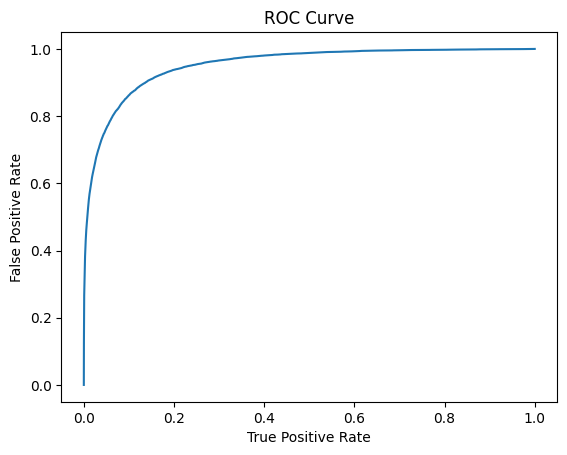

Train areaUnderROC: 0.9521835468307621


In [25]:
trainingSummary_toxic = lrModel_toxic.summary
roc_toxic = trainingSummary_toxic.roc.toPandas()
plt.plot(roc_toxic['FPR'],roc_toxic['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Train areaUnderROC: ' + str(trainingSummary_toxic.areaUnderROC))

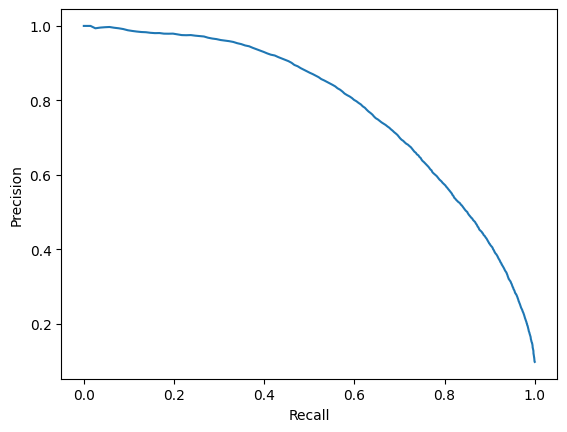

In [26]:
pr_toxic = trainingSummary_toxic.pr.toPandas()
plt.plot(pr_toxic['recall'],pr_toxic['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [27]:
test_toxic_pred = lrModel_toxic.transform(test_toxic)
test_toxic_pred.select('toxic', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|toxic|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[4.53182795481656...|       0.0|[0.98935357852386...|
|    1|[-3.1312787692845...|       1.0|[0.04183531738999...|
|    0|[5.43857249839817...|       0.0|[0.99567312092827...|
|    1|[0.98286338873388...|       0.0|[0.72767600563327...|
|    0|[2.59609014455276...|       0.0|[0.93060952371606...|
|    0|[3.93515274421024...|       0.0|[0.98083188296723...|
|    0|[5.67254222197075...|       0.0|[0.99657267577960...|
|    0|[3.85548400194006...|       0.0|[0.97927524762361...|
|    0|[3.85739307217615...|       0.0|[0.97931395722665...|
|    1|[-18.267386418910...|       1.0|[1.16566800015760...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



**Confusion matrix: toxic**

In [28]:
test_toxic_pred.groupBy('toxic', 'prediction').count().show()

+-----+----------+-----+
|toxic|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1333|
|    0|       0.0|28214|
|    1|       1.0| 1672|
|    0|       1.0|  330|
+-----+----------+-----+



### 2. label: severe_toxic

In [29]:
train_severe_toxic = train.select('features','severe_toxic')
test_severe_toxic = test.select('features','severe_toxic')

lr_severe_toxic = LogisticRegression(featuresCol='features', labelCol='severe_toxic')
lrModel_severe_toxic = lr_severe_toxic.fit(train_severe_toxic)

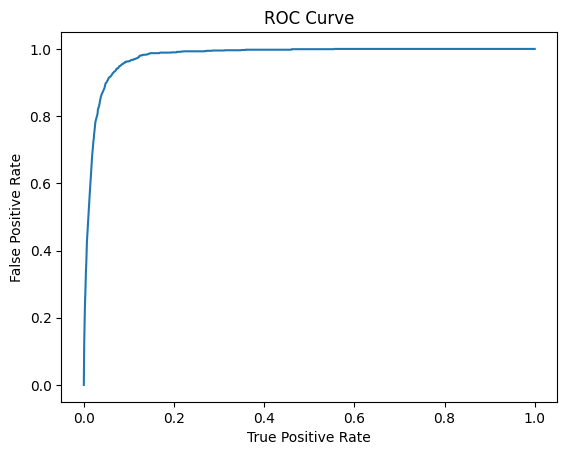

Train areaUnderROC: 0.9782723108904602


In [30]:
trainingSummary_severe_toxic = lrModel_severe_toxic.summary
roc_severe_toxic = trainingSummary_severe_toxic.roc.toPandas()
plt.plot(roc_severe_toxic['FPR'],roc_severe_toxic['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Train areaUnderROC: ' + str(trainingSummary_severe_toxic.areaUnderROC))

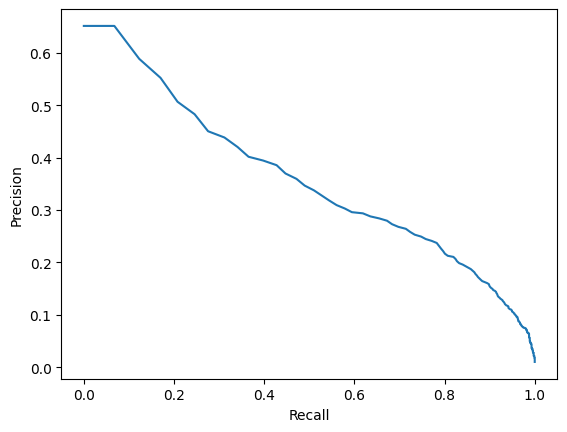

In [31]:
pr_severe_toxic = trainingSummary_severe_toxic.pr.toPandas()
plt.plot(pr_severe_toxic['recall'],pr_severe_toxic['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [32]:
test_severe_toxic_pred = lrModel_severe_toxic.transform(test_severe_toxic)
test_severe_toxic_pred.select('severe_toxic', 'rawPrediction', 'prediction', 'probability').show(10)

+------------+--------------------+----------+--------------------+
|severe_toxic|       rawPrediction|prediction|         probability|
+------------+--------------------+----------+--------------------+
|           0|[4.65143346963163...|       0.0|[0.99054239483658...|
|           0|[2.85957957111209...|       0.0|[0.94581175578682...|
|           0|[5.40091084218190...|       0.0|[0.99550780198080...|
|           0|[5.44746702942463...|       0.0|[0.99571127151699...|
|           0|[5.68610431135946...|       0.0|[0.99661868757468...|
|           0|[6.19944828454517...|       0.0|[0.99797356416705...|
|           0|[6.69069562790352...|       0.0|[0.99875912347607...|
|           0|[6.11912213975358...|       0.0|[0.99780444432412...|
|           0|[5.38417732599146...|       0.0|[0.99543234549890...|
|           0|[0.52802584316706...|       0.0|[0.62902255365006...|
+------------+--------------------+----------+--------------------+
only showing top 10 rows



**Confusion matrix: severe_toxic**

In [33]:
test_severe_toxic_pred.groupBy('severe_toxic', 'prediction').count().show()

+------------+----------+-----+
|severe_toxic|prediction|count|
+------------+----------+-----+
|           1|       0.0|  240|
|           0|       0.0|31158|
|           1|       1.0|   71|
|           0|       1.0|   80|
+------------+----------+-----+



### 3. label: obscene

In [34]:
train_obscene = train.select('features','obscene')
test_obscene = test.select('features','obscene')

lr_obscene = LogisticRegression(featuresCol='features', labelCol='obscene')
lrModel_obscene = lr_obscene.fit(train_obscene)

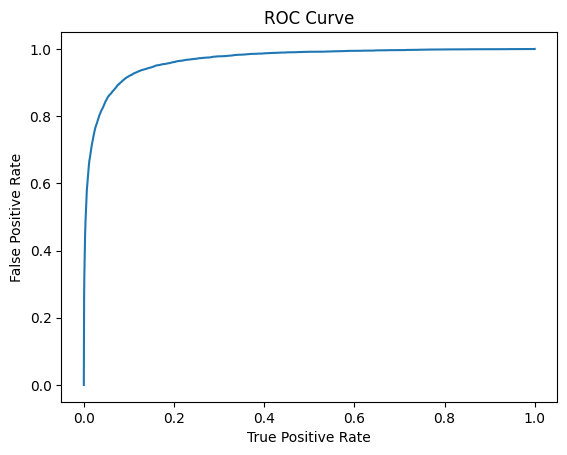

Train areaUnderROC: 0.9673219325643501


In [35]:
trainingSummary_obscene = lrModel_obscene.summary
roc_obscene = trainingSummary_obscene.roc.toPandas()
plt.plot(roc_obscene['FPR'],roc_obscene['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Train areaUnderROC: ' + str(trainingSummary_obscene.areaUnderROC))

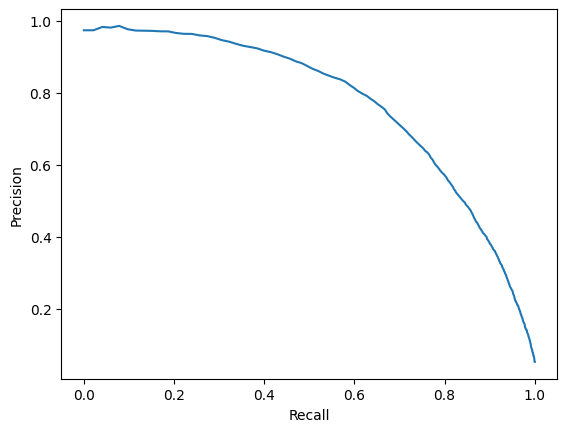

In [36]:
pr_obscene = trainingSummary_obscene.pr.toPandas()
plt.plot(pr_obscene['recall'],pr_obscene['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [37]:
test_obscene_pred = lrModel_obscene.transform(test_obscene)
test_obscene_pred.select('obscene', 'rawPrediction', 'prediction', 'probability').show(10)

+-------+--------------------+----------+--------------------+
|obscene|       rawPrediction|prediction|         probability|
+-------+--------------------+----------+--------------------+
|      0|[4.74829466084692...|       0.0|[0.99140800037192...|
|      0|[0.03739702991906...|       0.0|[0.50934816802459...|
|      0|[5.73833719609523...|       0.0|[0.99679021762750...|
|      1|[2.48586063082488...|       0.0|[0.92314463404162...|
|      0|[4.03681189616801...|       0.0|[0.98265258100467...|
|      0|[4.50582656339776...|       0.0|[0.98907619008529...|
|      0|[5.53588059211775...|       0.0|[0.99607274894548...|
|      0|[4.65523491969826...|       0.0|[0.99057794109625...|
|      0|[4.96305057657105...|       0.0|[0.99305697566224...|
|      1|[-15.802176729798...|       1.0|[1.37151886183699...|
+-------+--------------------+----------+--------------------+
only showing top 10 rows



**Confusion matrix: obscene**

In [38]:
test_obscene_pred.groupBy('obscene', 'prediction').count().show()

+-------+----------+-----+
|obscene|prediction|count|
+-------+----------+-----+
|      1|       0.0|  767|
|      0|       0.0|29688|
|      1|       1.0|  904|
|      0|       1.0|  190|
+-------+----------+-----+



### 4. label: threat

In [39]:
train_threat = train.select('features','threat')
test_threat = test.select('features','threat')

lr_threat = LogisticRegression(featuresCol='features', labelCol='threat')
lrModel_threat = lr_threat.fit(train_threat)

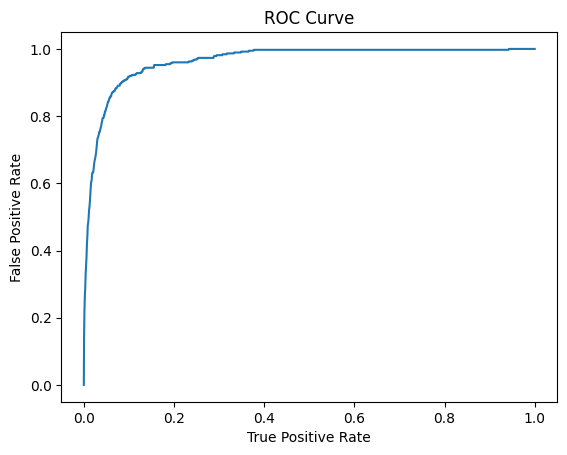

Train areaUnderROC: 0.9643031418186038


In [40]:
trainingSummary_threat = lrModel_threat.summary
roc_threat = trainingSummary_threat.roc.toPandas()
plt.plot(roc_threat['FPR'],roc_threat['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Train areaUnderROC: ' + str(trainingSummary_threat.areaUnderROC))

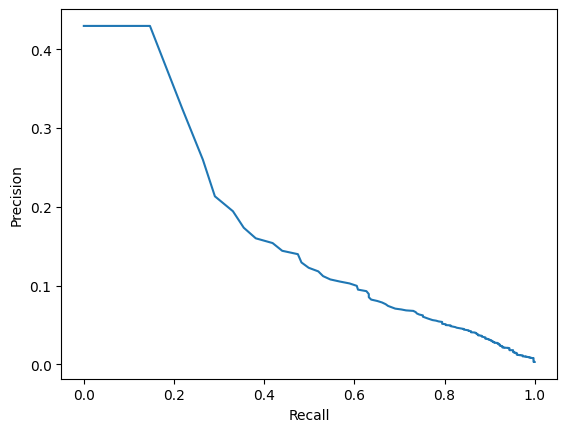

In [41]:
pr_threat = trainingSummary_threat.pr.toPandas()
plt.plot(pr_threat['recall'],pr_threat['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [42]:
test_threat_pred = lrModel_threat.transform(test_threat)
test_threat_pred.select('threat', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|threat|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     0|[5.04558882870878...|       0.0|[0.99360350991957...|
|     0|[2.15970963920198...|       0.0|[0.89657262644107...|
|     0|[7.23606539957097...|       0.0|[0.99928037857298...|
|     0|[7.59348449421284...|       0.0|[0.99949653083558...|
|     0|[6.47352063311661...|       0.0|[0.99845859851895...|
|     0|[7.66555311058489...|       0.0|[0.99953152213232...|
|     0|[8.43943189152119...|       0.0|[0.99978387379555...|
|     0|[7.34755766005052...|       0.0|[0.99935625097231...|
|     0|[6.24126345403467...|       0.0|[0.99805639144506...|
|     0|[3.44608325757281...|       0.0|[0.96911412009747...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



**Confusion matrix: threat**

In [43]:
test_threat_pred.groupBy('threat', 'prediction').count().show()

+------+----------+-----+
|threat|prediction|count|
+------+----------+-----+
|     1|       0.0|   95|
|     0|       0.0|31434|
|     1|       1.0|    5|
|     0|       1.0|   15|
+------+----------+-----+



### 5. label: insult

In [44]:
train_insult = train.select('features','insult')
test_insult = test.select('features','insult')

lr_insult = LogisticRegression(featuresCol='features', labelCol='insult')
lrModel_insult = lr_insult.fit(train_insult)

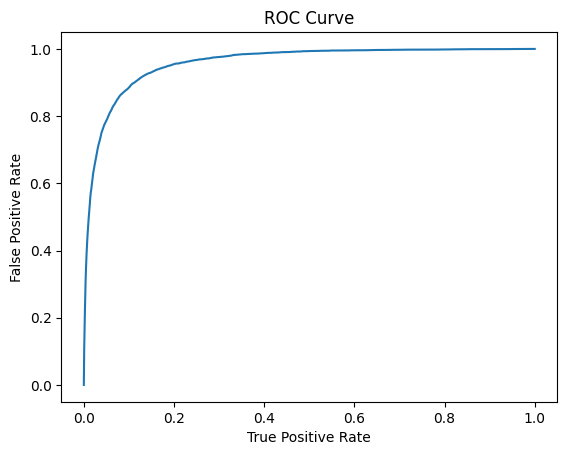

Train areaUnderROC: 0.9582378796798813


In [45]:
trainingSummary_insult = lrModel_insult.summary
roc_insult = trainingSummary_insult.roc.toPandas()
plt.plot(roc_insult['FPR'],roc_insult['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Train areaUnderROC: ' + str(trainingSummary_insult.areaUnderROC))

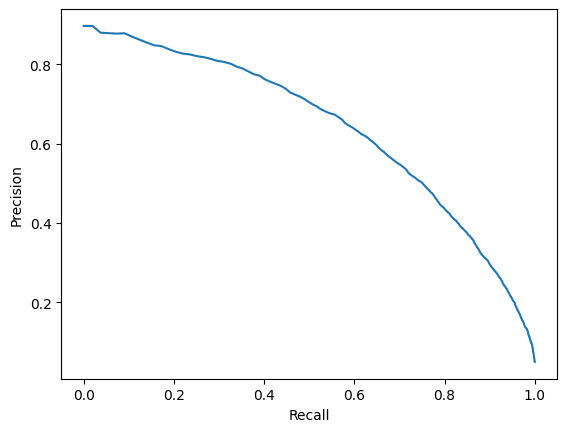

In [46]:
pr_insult = trainingSummary_insult.pr.toPandas()
plt.plot(pr_insult['recall'],pr_insult['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [47]:
test_insult_pred = lrModel_insult.transform(test_insult)
test_insult_pred.select('insult', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|insult|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     0|[4.09429817042512...|       0.0|[0.98360580930656...|
|     0|[-0.1717514531483...|       1.0|[0.45716737671491...|
|     0|[5.46233552892552...|       0.0|[0.99577429928889...|
|     1|[2.33081253503291...|       0.0|[0.91139697294231...|
|     0|[3.40819550223728...|       0.0|[0.96795968553243...|
|     0|[5.04804744941845...|       0.0|[0.99361911691961...|
|     0|[5.36359009228979...|       0.0|[0.99533777844497...|
|     0|[4.06639314969990...|       0.0|[0.98314970352913...|
|     0|[3.86345530900951...|       0.0|[0.97943641062133...|
|     1|[-5.2128723224863...|       1.0|[0.00541651014764...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



**Confusion matrix: insult**

In [48]:
test_insult_pred.groupBy('insult', 'prediction').count().show()

+------+----------+-----+
|insult|prediction|count|
+------+----------+-----+
|     1|       0.0|  906|
|     0|       0.0|29763|
|     1|       1.0|  647|
|     0|       1.0|  233|
+------+----------+-----+



### 6. label: identity_hate

In [49]:
train_identity_hate = train.select('features','identity_hate')
test_identity_hate = test.select('features','identity_hate')

lr_identity_hate = LogisticRegression(featuresCol='features', labelCol='identity_hate')
lrModel_identity_hate = lr_identity_hate.fit(train_identity_hate)

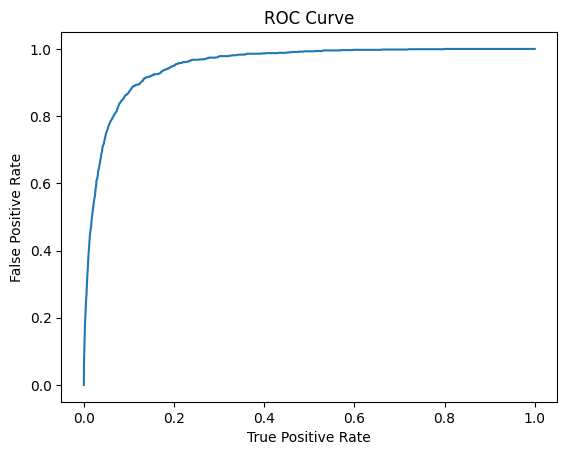

Train areaUnderROC: 0.9523323578906918


In [50]:
trainingSummary_identity_hate = lrModel_identity_hate.summary
roc_identity_hate = trainingSummary_identity_hate.roc.toPandas()
plt.plot(roc_identity_hate['FPR'],roc_identity_hate['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Train areaUnderROC: ' + str(trainingSummary_identity_hate.areaUnderROC))

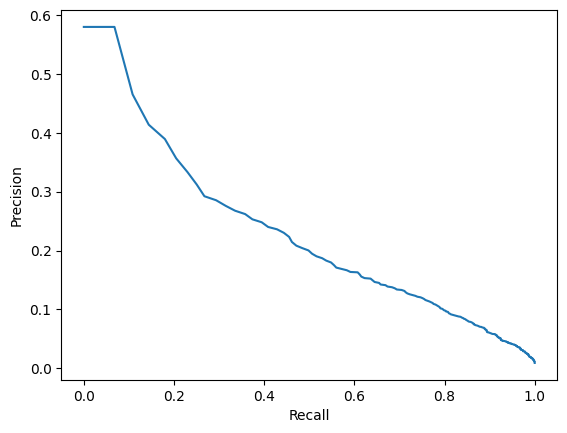

In [51]:
pr_identity_hate = trainingSummary_identity_hate.pr.toPandas()
plt.plot(pr_identity_hate['recall'],pr_identity_hate['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [52]:
test_identity_hate_pred = lrModel_identity_hate.transform(test_identity_hate)
test_identity_hate_pred.select('identity_hate', 'rawPrediction', 'prediction', 'probability').show(10)

+-------------+--------------------+----------+--------------------+
|identity_hate|       rawPrediction|prediction|         probability|
+-------------+--------------------+----------+--------------------+
|            0|[6.06458482544560...|       0.0|[0.99768166460350...|
|            0|[2.00373551490444...|       0.0|[0.88118872551749...|
|            0|[5.70534016008624...|       0.0|[0.99668289471722...|
|            0|[5.34933004150909...|       0.0|[0.99527113528227...|
|            0|[5.06288021344937...|       0.0|[0.99371247388011...|
|            0|[6.15750170284623...|       0.0|[0.99788693758228...|
|            0|[5.92070475304341...|       0.0|[0.99732387243504...|
|            0|[5.77599726482859...|       0.0|[0.99690848361764...|
|            0|[5.60045141460405...|       0.0|[0.99631741672174...|
|            0|[2.20308010697072...|       0.0|[0.90052576471251...|
+-------------+--------------------+----------+--------------------+
only showing top 10 rows



**Confusion matrix: identity_hate**

In [53]:
test_identity_hate_pred.groupBy('identity_hate', 'prediction').count().show()

+-------------+----------+-----+
|identity_hate|prediction|count|
+-------------+----------+-----+
|            1|       0.0|  247|
|            0|       0.0|31235|
|            1|       1.0|   35|
|            0|       1.0|   32|
+-------------+----------+-----+



In [54]:
spark.stop()

### Вывод: Word2Vec показывает лучшее качество даже при длине вектора в 100 против TF-IDF при длине вектора в 1024.